In [198]:
import os
from gymnasium import Env
from gymnasium import spaces
from gymnasium.spaces import Discrete
import pandas as pd
import numpy as np

from stable_baselines3 import DQN
from stable_baselines3 import PPO

from stable_baselines3 import A2C
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike



In [199]:
carbon_intensity = pd.read_csv('Datasets/Carbon_intensity_processed_hourly.csv')
electricity_usage = pd.read_csv('Datasets/Household_processed_hourly.csv')

In [200]:
carbon_intensity['Datetime (UTC)'] = pd.to_datetime(carbon_intensity['Datetime (UTC)'], utc=True)
carbon_intensity = carbon_intensity.set_index('Datetime (UTC)')
carbon_intensity.index = carbon_intensity.index.tz_convert(None)
carbon_intensity = carbon_intensity['Carbon Intensity gCO₂eq/kWh (LCA)']


342.0532374100719


<Axes: xlabel='Datetime (UTC)', ylabel='Carbon Intensity'>

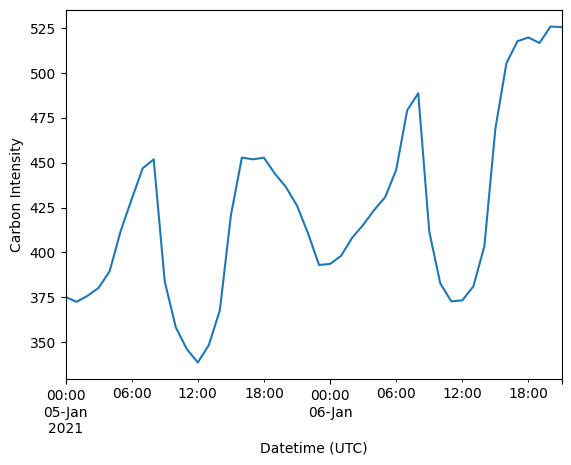

In [201]:
# c_int = np.asarray(carbon_intensity['2021-07-05 00:00:00':'2021-12-05 21:00:00'],dtype=int)
c_int = np.asarray(carbon_intensity['2021-07-05 00:00:00':'2021-08-31 21:00:00'],dtype=int)
c_mean = c_int.mean()
print(c_mean)
carbon_intensity['2021-01-05 00:00:00':'2021-01-06 21:00:00'].plot(ylabel = 'Carbon Intensity')

In [202]:
electricity_usage['date'] = pd.to_datetime(electricity_usage['date'], utc=True)
electricity_usage= electricity_usage.set_index('date')
electricity_usage.index = electricity_usage.index.tz_convert(None)
electricity_usage = electricity_usage['energy meter val']

In [203]:
e_usage = np.asarray([(i * 10) for i in electricity_usage['2015-07-05 00:00:00':]], dtype=int)
e_mean = e_usage.mean()
print(e_mean)

1106.9382782891175


----------------------

In [204]:
# Global evaluation vars
evaluation_data = pd.DataFrame()
old_emission_difference = [0]
hourly_emission_difference = []
hourly_battery_level = []
hourly_baseline_em = []
hourly_battery_em = []
decision_hist = []
reward_hist = []
total_emissions_saved = 0
total_baseline_em = []

In [205]:
# Environment Constants
arr_start_point = 0 # where in the e_usage and c_int arrays to start
env_length = 720 # number of hours ==> 720 = 30 days
battery_size = 1000 #Watt/Hour
charge_discharge_rate = battery_size/4 #Watt/Hour

In [206]:
def calculate_emissions_standard(c_int, e_usage):
    em = c_int * (e_usage/1000)
    return em

In [207]:
y_em_count = 0
for elem in c_int:
    y_em_count += calculate_emissions_standard(elem, e_mean)
print(f'yearly emissions: {y_em_count/1000}')

yearly emissions: 526.2982321656746


In [208]:
def calculate_emissions_when_discharge(curr_c_int, e_usage):
    em_new = 0
    if e_usage > charge_discharge_rate:
        em_new = calculate_emissions_standard(curr_c_int, e_usage - charge_discharge_rate)
    return em_new

In [209]:
def discharge_bat_smart(e_usage, curr_charge):
    if e_usage >= charge_discharge_rate:
        return curr_charge - charge_discharge_rate
    else:
        return curr_charge - e_usage 

In [210]:
def check_illegal_action(action, curr_charge):
    if action == 0 and curr_charge <= 0:
        return True
    elif action == 2 and curr_charge >= battery_size:
        return True
    else:
        return False

In [211]:
def eval_battery_level_and_emissions(emissions, battery_val):
    hourly_battery_em.append(emissions)
    hourly_battery_level.append(battery_val)
    

In [212]:
# def reward_algo(self, action):
#     if action == 1:
#         old_emission_difference.append(old_emission_difference[-1])
#         reward_hist.append(-0.1)
#         return -0.01
#     curr_delta = self.emissions_baseline - self.emissions_with_battery
#     # curr_delta = abs(self.emissions_with_battery - self.emissions_baseline)
#     if curr_delta > self.state["max_emission_delta"]:
#         self.state.update({"max_emission_delta" : np.array([curr_delta])})
#         old_emission_difference.append(curr_delta)
#         reward_hist.append(1)
#         return 1
#     else:
#         old_emission_difference.append(old_emission_difference[-1])
#         reward_hist.append(-0.01)
#         return -0.01

In [213]:
def reward_algo(self, action):
    if action == 1:
        old_emission_difference.append(old_emission_difference[-1])
        reward_hist.append(-0.1)
        return -0.01
    curr_delta = self.emissions_baseline - self.emissions_with_battery
    # curr_delta = abs(self.emissions_with_battery - self.emissions_baseline)
    if curr_delta > self.state["max_emission_delta"]:
        self.state.update({"max_emission_delta" : np.array([curr_delta])})
        old_emission_difference.append(curr_delta)
        reward_hist.append(1)
        return 1
    else:
        old_emission_difference.append(old_emission_difference[-1])
        reward_hist.append(-0.01)
        return -0.02

In [214]:
def is_done(self):
    if self.length == 0:
        print(f'TOTAL EMISSIONS: {self.emissions_baseline}')
        total_baseline_em.append(self.emissions_baseline)
        return True
    else:
        return False

In [215]:
class Environment(Env):
    def __init__(self):
        super().__init__()
        # Actions are discharge(-1), nothing (0) and charge (1)
        self.action_space = Discrete(3)
        self.observation_space = spaces.Dict({
                "carbon_int" : spaces.Box(low = 0, high = 100000, shape=(1,), dtype=int),
                "electric_usage" : spaces.Box(low = 0, high = 10000, shape=(1,), dtype=int),
                "battery_charge" : spaces.Box(low = 0, high = battery_size, shape=(1,), dtype=int),
                "max_emission_delta" : spaces.Box(low = -np.inf, high = np.inf, shape=(1,), dtype=int)
            }
        )            
        
        self.c_int = c_int
        self.e_usage = e_usage
        self.length = env_length
        self.hour_index = arr_start_point
        
        self.emissions_baseline = 0
        self.emissions_with_battery = 0
        
        self.state = {
            "carbon_int": np.array([self.c_int[arr_start_point]]),
            "electric_usage": np.array([self.e_usage[arr_start_point]]),
            "battery_charge": np.array([0]),
            "max_emission_delta": np.array([0]),
        }
        
        
    def step(self, action):
        curr_c_int = self.state["carbon_int"]
        curr_e_usage = self.state["electric_usage"]
        curr_charge = self.state["battery_charge"]
        
        
        # Update baseline emissions in env and in evaluation
        baseline_em_now = calculate_emissions_standard(curr_c_int, curr_e_usage)
        self.emissions_baseline = self.emissions_baseline + baseline_em_now
        hourly_baseline_em.append(baseline_em_now)
        
        # was_illegal_action = False
        
        # Perform 'game logic' for each possible agent action
        if action == 0 and curr_charge > 0:
            decision_hist.append("Discharged")
            if curr_charge > charge_discharge_rate:
                emissions_now = calculate_emissions_when_discharge(curr_c_int, curr_e_usage)
                self.emissions_with_battery = self.emissions_with_battery + emissions_now
                new_battery_charge_val = discharge_bat_smart(curr_e_usage,curr_charge)
                eval_battery_level_and_emissions(emissions_now,new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
            elif 0 <= curr_charge <= charge_discharge_rate:
                emissions_now = calculate_emissions_when_discharge(curr_c_int, curr_e_usage)
                self.emissions_with_battery = self.emissions_with_battery + emissions_now
                new_battery_charge_val = np.array([0])
                eval_battery_level_and_emissions(emissions_now,new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
            
        elif action == 1 and 0 <= curr_charge <= battery_size:
            decision_hist.append("Nothing")
            emissions_now = calculate_emissions_standard(curr_c_int, curr_e_usage)
            eval_battery_level_and_emissions(emissions_now,curr_charge)
            self.emissions_with_battery = self.emissions_with_battery + emissions_now
            
        elif action == 2 and curr_charge < battery_size:
            decision_hist.append("Charged")
            if (battery_size - charge_discharge_rate) <= curr_charge < battery_size:
                emissions_now = calculate_emissions_standard(curr_c_int, curr_e_usage + (battery_size - curr_charge))
                self.emissions_with_battery = self.emissions_with_battery + emissions_now
                new_battery_charge_val = np.array([battery_size])
                
                eval_battery_level_and_emissions(emissions_now,new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
            elif 0 <= curr_charge < (battery_size - charge_discharge_rate):
                emissions_now = calculate_emissions_standard(curr_c_int, curr_e_usage + charge_discharge_rate)
                self.emissions_with_battery = self.emissions_with_battery + emissions_now
                new_battery_charge_val = curr_charge + charge_discharge_rate
                eval_battery_level_and_emissions(emissions_now,new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
        else:
            # was_illegal_action = check_illegal_action(action, curr_charge)
            decision_hist.append("Illegal action")
            emissions_now = calculate_emissions_standard(curr_c_int, curr_e_usage)
            eval_battery_level_and_emissions(emissions_now,curr_charge)
            self.emissions_with_battery = self.emissions_with_battery + emissions_now
            
        
        # Some eval metrics
        # hourly_emission_difference.append(abs(self.emissions_with_battery - self.emissions_baseline))
        hourly_emission_difference.append(self.emissions_baseline - self.emissions_with_battery)
        
        # Update env variables
        self.length = self.length - 1
        self.hour_index = self.hour_index + 1
        # Go to next state
        self.state.update({"carbon_int": np.array([self.c_int[self.hour_index]])})
        self.state.update({"electric_usage": np.array([self.e_usage[self.hour_index]])})

        # Update reward
        # reward = reward_algo(self, was_illegal_action)
        reward = reward_algo(self, action)
        
        # Check if finished
        done = is_done(self)
        
        info = {}
        truncated = False
        return self.state, reward, done, truncated, info
    
    
    def reset(self, seed = None, options = None):
        self.state = {
            "carbon_int": np.array([self.c_int[arr_start_point]]),
            "electric_usage": np.array([self.e_usage[arr_start_point]]),
            "battery_charge": np.array([0]),
            "max_emission_delta" : np.array([0]),
        } 
        self.c_int = c_int
        self.e_usage = e_usage
        self.length = env_length
        self.hour_index = arr_start_point
        self.emissions_baseline = 0
        self.emissions_with_battery = 0

        info = {}
        
        return self.state, info

In [216]:
env = Environment()

PPO Agent 200k time step training

In [217]:
log_path_ppo = os.path.join('Training', 'Logs', 'PPO')

In [218]:
# modelPPO = PPO("MultiInputPolicy", env, ent_coef=0.01, verbose=1, tensorboard_log = log_path_ppo)


In [219]:
# modelPPO.learn(total_timesteps=200000)

In [220]:
PPO_model_path = os.path.join("Training", "Saved Models", "PPO_MODEL_200k_1kWh")

In [221]:
# modelPPO.save(PPO_model_path)

In [222]:
modelPPO = PPO.load(PPO_model_path)

In [223]:
episodes = 30
score = np.zeros(episodes)
saved = np.empty(episodes)
for episode in range(1, episodes+1):
    obs, inf = env.reset()
    evaluation_data = pd.DataFrame(None)
    old_emission_difference.clear()
    old_emission_difference.append(np.array([0]))
    hourly_emission_difference.clear()
    hourly_battery_level.clear()
    hourly_baseline_em.clear()
    hourly_battery_em.clear()
    decision_hist.clear()
    reward_hist.clear()
    total_baseline_em.clear()
    done = False

    while not done:
        action, _ = modelPPO.predict(obs) # Random actions here
        obs, reward, done, truncated, info = env.step(action)
        score[episode-1] += reward
    saved[episode-1] = np.squeeze((100*old_emission_difference[-1])/total_baseline_em)
    print('Episode: {} Reward: {} Percentage Saved: {}'.format(episode, score[episode-1],saved[episode-1]))
    print()

print('Average reward: {} Average saved %: {}'.format(score.mean(), saved.mean()))

evaluation_data.insert(0,column="energy_usage",value=pd.Series(e_usage[:env_length]))
evaluation_data.insert(1,column="carbon_intensity",value=pd.Series(c_int[:env_length]))
evaluation_data.insert(2,column="battery_level",value=pd.Series(hourly_battery_level))
evaluation_data.insert(3,column="decision",value=pd.Series(decision_hist))
evaluation_data.insert(4,column="emission_baseline",value=pd.Series(hourly_baseline_em))
evaluation_data.insert(5,column="emission_w_battery",value=pd.Series(hourly_battery_em))
evaluation_data.insert(6,column="max_em_delta",value=pd.Series(old_emission_difference))
evaluation_data.insert(7,column="emission_delta",value=pd.Series(hourly_emission_difference))
evaluation_data.insert(8,column="emission_baseline_sum",value=pd.Series(total_baseline_em))
evaluation_data.insert(9,column="reward",value=pd.Series(reward_hist))

TOTAL EMISSIONS: [326634.834]
Episode: 1 Reward: 33.11000000000003 Percentage Saved: 0.41169828200258646
TOTAL EMISSIONS: [326634.834]
Episode: 2 Reward: 33.16000000000004 Percentage Saved: 0.37082695227782775
TOTAL EMISSIONS: [326634.834]
Episode: 3 Reward: 36.14999999999999 Percentage Saved: 0.43649661689175506
TOTAL EMISSIONS: [326634.834]
Episode: 4 Reward: 18.670000000000154 Percentage Saved: 0.3679950436639412
TOTAL EMISSIONS: [326634.834]
Episode: 5 Reward: 36.559999999999874 Percentage Saved: 0.4681068400683805
TOTAL EMISSIONS: [326634.834]
Episode: 6 Reward: 32.29000000000004 Percentage Saved: 0.4358843123265904
TOTAL EMISSIONS: [326634.834]
Episode: 7 Reward: 32.02000000000006 Percentage Saved: 0.3591166274690715
TOTAL EMISSIONS: [326634.834]
Episode: 8 Reward: 28.930000000000117 Percentage Saved: 0.3718984852668659
TOTAL EMISSIONS: [326634.834]
Episode: 9 Reward: 27.020000000000103 Percentage Saved: 0.3983041196395917
TOTAL EMISSIONS: [326634.834]
Episode: 10 Reward: 15.2400

In [224]:
# evaluation_data.to_csv("evaluation.csv")

Percentage CO2 Saved: [[0.42417399]]
Total emissions: [array([326634.834])]
Final delta: 1385.5


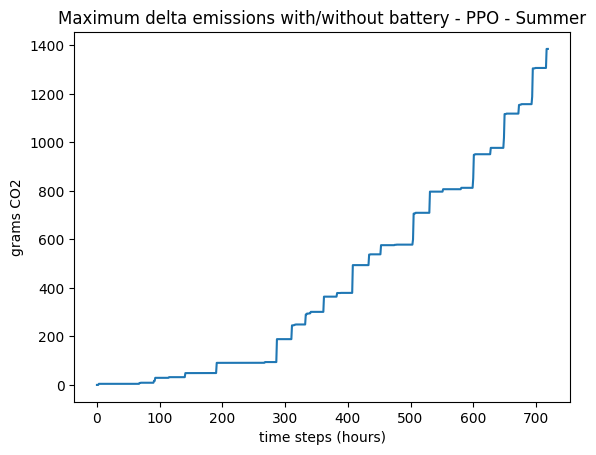

In [225]:
temp = map(lambda x: x[0], evaluation_data["max_em_delta"])    
series = pd.Series(temp)
series.plot(xlabel = "time steps (hours)", ylabel = "grams CO2",title="Maximum delta emissions with/without battery - PPO - Summer")
print(f'Percentage CO2 Saved: {(100 * series.iloc[-1])/total_baseline_em}')
print(f'Total emissions: {total_baseline_em}')
print(f'Final delta: {series.iloc[-1]}')


Final delta: 1264.75


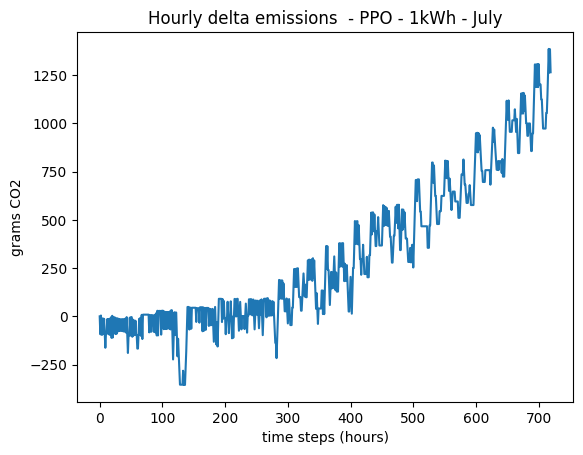

In [226]:
temp = map(lambda x: x[0], evaluation_data["emission_delta"])    
series = pd.Series(temp)
series.plot(xlabel = "time steps (hours)", ylabel = "grams CO2",title="Hourly delta emissions  - PPO - 1kWh - July")
print(f'Final delta: {series.iloc[-1]}')

<Axes: title={'center': 'Battery Charge Vals - PPO - Summer'}, xlabel='time steps (hours)', ylabel='battery charge value (Wh)'>

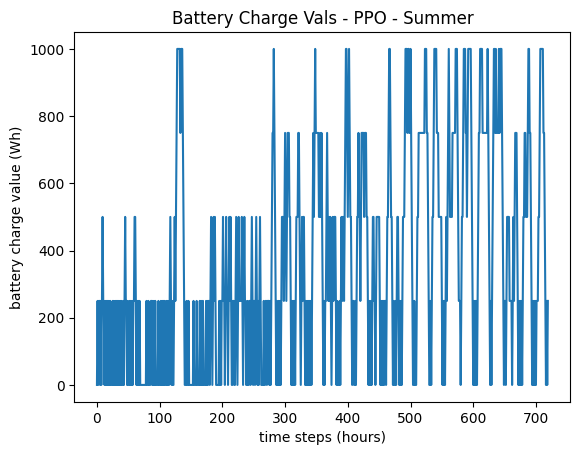

In [227]:
temp = map(lambda x: x[0], evaluation_data["battery_level"])
series = pd.Series(temp)
series.plot(xlabel = "time steps (hours)", ylabel = "battery charge value (Wh)",title="Battery Charge Vals - PPO - Summer")

<Axes: title={'center': 'Battery Charge Hist - PPO - Summer'}, xlabel='battery charge value (Wh)', ylabel='frequency'>

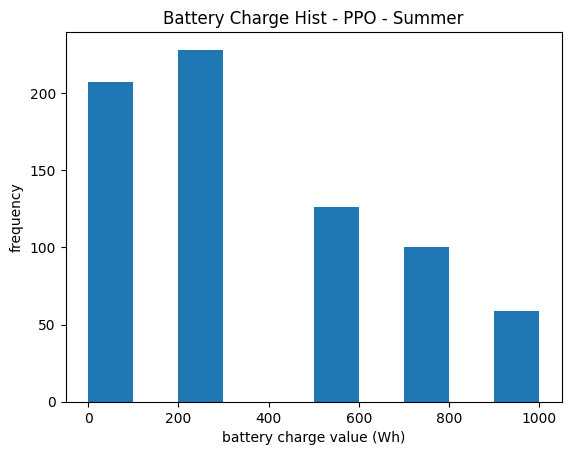

In [228]:
temp = map(lambda x: x[0], evaluation_data["battery_level"])
series = pd.Series(temp)
series.plot(kind ="hist", xlabel = "battery charge value (Wh)", ylabel = "frequency",title="Battery Charge Hist - PPO - Summer")

Deep Q-Network Model 200k time step training

In [229]:
# log_path_dqn = os.path.join('Training', 'Logs','DQN')
# # modelDQN = DQN('MultiInputPolicy', env, verbose = 1, learning_starts = 720, gamma= 0.95, tensorboard_log = log_path_dqn)
# modelDQN = DQN('MultiInputPolicy', env, verbose = 1, tensorboard_log = log_path_dqn, learning_starts=720,gamma=0.97, exploration_final_eps=0.1, exploration_fraction=0.2)

In [230]:
# modelDQN.learn(total_timesteps=80000)

In [231]:
# DQN_model_path = os.path.join("Training", "Saved Models", "DQN_MODEL_200k_7kWh")

In [232]:
# modelDQN.save(DQN_model_path)

In [233]:
# modelDNQ = DQN.load(DQN_model_path)

In [234]:
# episodes = 30
# score = np.zeros(episodes)
# saved = np.empty(episodes)
# for episode in range(1, episodes+1):
#     obs, inf = env.reset()
#     evaluation_data = pd.DataFrame(None)
#     old_emission_difference.clear()
#     old_emission_difference.append(np.array([0]))
#     hourly_emission_difference.clear()
#     hourly_battery_level.clear()
#     hourly_baseline_em.clear()
#     hourly_battery_em.clear()
#     decision_hist.clear()
#     reward_hist.clear()
#     total_baseline_em.clear()
#     done = False
# 
#     while not done:
#         action, _ = modelDQN.predict(obs) # Random actions here
#         obs, reward, done, truncated, info = env.step(action)
#         score[episode-1] += reward
#     saved[episode-1] = np.squeeze((100*old_emission_difference[-1])/total_baseline_em)
#     print('Episode: {} Reward: {} Percentage Saved: {}'.format(episode, score[episode-1],saved[episode-1]))
#     print()
# 
# print('Average reward: {} Average saved %: {}'.format(score.mean(), saved.mean()))
# 
# evaluation_data.insert(0,column="energy_usage",value=pd.Series(e_usage[:env_length]))
# evaluation_data.insert(1,column="carbon_intensity",value=pd.Series(c_int[:env_length]))
# evaluation_data.insert(2,column="battery_level",value=pd.Series(hourly_battery_level))
# evaluation_data.insert(3,column="decision",value=pd.Series(decision_hist))
# evaluation_data.insert(4,column="emission_baseline",value=pd.Series(hourly_baseline_em))
# evaluation_data.insert(5,column="emission_w_battery",value=pd.Series(hourly_battery_em))
# evaluation_data.insert(6,column="max_em_delta",value=pd.Series(old_emission_difference))
# evaluation_data.insert(7,column="emission_delta",value=pd.Series(hourly_emission_difference))
# evaluation_data.insert(8,column="emission_baseline_sum",value=pd.Series(total_baseline_em))
# evaluation_data.insert(9,column="reward",value=pd.Series(reward_hist))

In [235]:
# evaluation_data.to_csv("evaluation.csv")

In [236]:
# my_list = map(lambda x: x[0], evaluation_data["max_em_delta"])
# ser = pd.Series(my_list)
# ser.plot()
# print(f'Final delta: {ser.iloc[-1]}')
# print(ser)

In [237]:
# temp = map(lambda x: x[0], evaluation_data["emission_delta"])    
# series = pd.Series(temp)
# series.plot(xlabel = "time steps (hours)", ylabel = "grams CO2",title="Hourly delta emissions")
# print(f'Final delta: {series.iloc[-1]}')

In [238]:
# my_list = map(lambda x: x[0], evaluation_data["battery_level"])
# ser = pd.Series(my_list)
# ser.plot()